In [29]:
%matplotlib inline
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math

# need to install line_profiler: username$ conda install line_profiler
# used to do a line-by-line analysis of the efficiency of the code
%load_ext line_profiler

# load cython to make random number generation faster
%load_ext Cython


# This function sets up more parameters and calls runSimulation
def startSimulation(nlive,D,krep,maxnbact):
    
    # Set up more simulation parameters
    delt = 0.01                                        # time step
    dTime = math.log(2)/krep                           # doubling time
    sigma = dTime/5                                    # width of distribution
    bactpos = np.zeros((int(maxnbact*1.1),2))          # positions of bacteria
    bacthist = np.zeros((int(maxnbact*1.1),1))         # time experience by bacteria
    bactrep = np.zeros((int(maxnbact*1.1),1))          # doubling times for bacteria
    maxstep = 1000                                     # max number of steps allowed
    bacteria_number = np.zeros((maxstep,1))            # keep track of number of bacteria
    time = np.zeros((maxstep,1))                       # keep track of passing time

    # assign doubling times to initial bacteria (normally distributed)
    bactrep[0:nlive] = np.random.normal(dTime, sigma, [nlive,1])

    return runSimulation(0,nlive,2*D*delt,delt,dTime,sigma,bactpos,bacthist,bactrep,bacteria_number)


# This function runs the simulation in a for loop until nlive>maxnact
def runSimulation(step,nlive,scaledD,delt,dTime,sigma,bactpos,bacthist,bactrep,bacteria_number):
    
    while(1):
        
        # Step 1: end simulation if you have accumulated enough bacteria
        if nlive>maxnbact:
            return bactpos,bacteria_number,nlive,step
    
        # Step 2: calculate time
        bacthist[0:nlive] = bacthist[0:nlive] + delt
    
        # Step 3: calculate size of bacterial steps
        delxy = np.multiply( np.array(my_gaussian_fast(2*nlive)).reshape(nlive,2), math.sqrt(scaledD))
        bactpos[0:nlive] = bactpos[0:nlive] + delxy
    
        # Step 4: replicate bacteria
        bacthist,newbact,nrep = repBacteria(bactpos[0:nlive],bactrep[0:nlive],bacthist,nlive)
        nlive += nrep
        bacteria_number[step] = nlive
        step+=1
        if nrep>0:
            bactpos[nlive:nlive+nrep] = newbact
            bactrep[nlive:nlive+nrep] = np.random.normal(dTime, sigma, [nrep,1])
            

# This function replicates bacteria when bacthist catches up with bacthist
def repBacteria(bactpos,bactrep,bacthist,nlive):
    repind = bactrep < bacthist[0:nlive]           #indices of bacteria that will replicate
    repind = repind.reshape(nlive)                 #reshape repind for indexing
    nrep = np.sum(repind)                          #number of bacteria that replicate
    newbact = bactpos[repind,:]                    #positions of newly-replicated bacteria
    bacthist[0:nlive][repind] = 0                  #bacterial history is reset to zero
    return bacthist,newbact,nrep

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [30]:
%%cython

# This code makes Gaussian random number generation faster than numpy

from libc.stdlib cimport rand, RAND_MAX
from libc.math cimport log, sqrt
import numpy as np
import cython

cdef double random_uniform():
    cdef double r = rand()
    return r / RAND_MAX

cdef double random_gaussian():
    cdef double x1, x2, w

    w = 2.0
    while (w >= 1.0):
        x1 = 2.0 * random_uniform() - 1.0
        x2 = 2.0 * random_uniform() - 1.0
        w = x1 * x1 + x2 * x2

    w = ((-2.0 * log(w)) / w) ** 0.5
    return x1 * w

@cython.boundscheck(False)
cdef void assign_random_gaussian_pair(double[:] out, int assign_ix):
    cdef double x1, x2, w

    w = 2.0
    while (w >= 1.0):
        x1 = 2.0 * random_uniform() - 1.0
        x2 = 2.0 * random_uniform() - 1.0
        w = x1 * x1 + x2 * x2

    w = sqrt((-2.0 * log(w)) / w)
    out[assign_ix] = x1 * w
    out[assign_ix + 1] = x2 * 2

@cython.boundscheck(False)
def my_gaussian_fast(int n):
    cdef int i
    cdef double[:] result = np.zeros(n, dtype='f8', order='C')
    for i in range(n // 2):  # Int division ensures trailing index if n is odd.
        assign_random_gaussian_pair(result, i * 2)
    if n % 2 == 1:
        result[n - 1] = random_gaussian()

    return result

In [31]:
### Use this block of code to run simulation

# Simulation parameters
D = 1.0                     # diffusion coefficient
krep = 1.0                  # replication rate
nlive = 25                  # initial number of bacteria
maxnbact = int(1e5)         # max number of bacteria

# Run simulation
bactpos,bacteria_number,maxlive,step = startSimulation(nlive,D,krep,maxnbact)

<function matplotlib.pyplot.show>

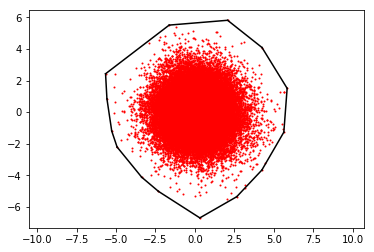

In [32]:
# Calculate convex hull of bacterial focus and plot it
hull = ConvexHull(bactpos)
plt.scatter(bactpos[0:maxlive][:,0], bactpos[0:maxlive][:,1],1,'r')
for simplex in hull.simplices:
    plt.plot(bactpos[simplex, 0], bactpos[simplex, 1], 'k-')
plt.axis('equal')
plt.show

<function matplotlib.pyplot.show>

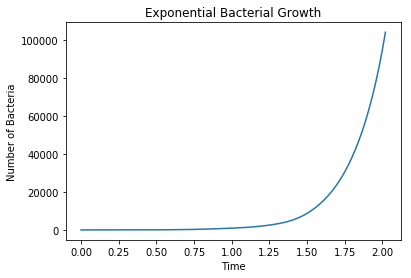

In [33]:
# Plot exponential bacterial growth
delt = 0.01
maxTime = step*delt
time = np.arange(0, maxTime, delt)
plt.plot(time[0:step],bacteria_number[0:step])
plt.xlabel('Time')
plt.ylabel('Number of Bacteria')
plt.title('Exponential Bacterial Growth')
plt.show

In [34]:
# Use this to profile the simulation line by line

%lprun -f runSimulation startSimulation(nlive,D,krep,maxnbact)